In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet121, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import shutil


%matplotlib inline

In [2]:
os.mkdir('augmented')

In [3]:
os.mkdir('./augmented/benign')
os.mkdir('./augmented/malignant')

In [4]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [5]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

In [6]:
files_benign=getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/benign')

In [7]:
files_malignant=getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/malignant')

In [10]:
benign_train = np.array(Dataset_loader('augmented/benign',224))
malign_train = np.array(Dataset_loader('augmented/malignant',224))
benign_test = np.array(Dataset_loader('augmented/benign',224))
malign_test = np.array(Dataset_loader('augmented/malignant',224))

100%|██████████| 5429/5429 [01:23<00:00, 64.64it/s]


In [11]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

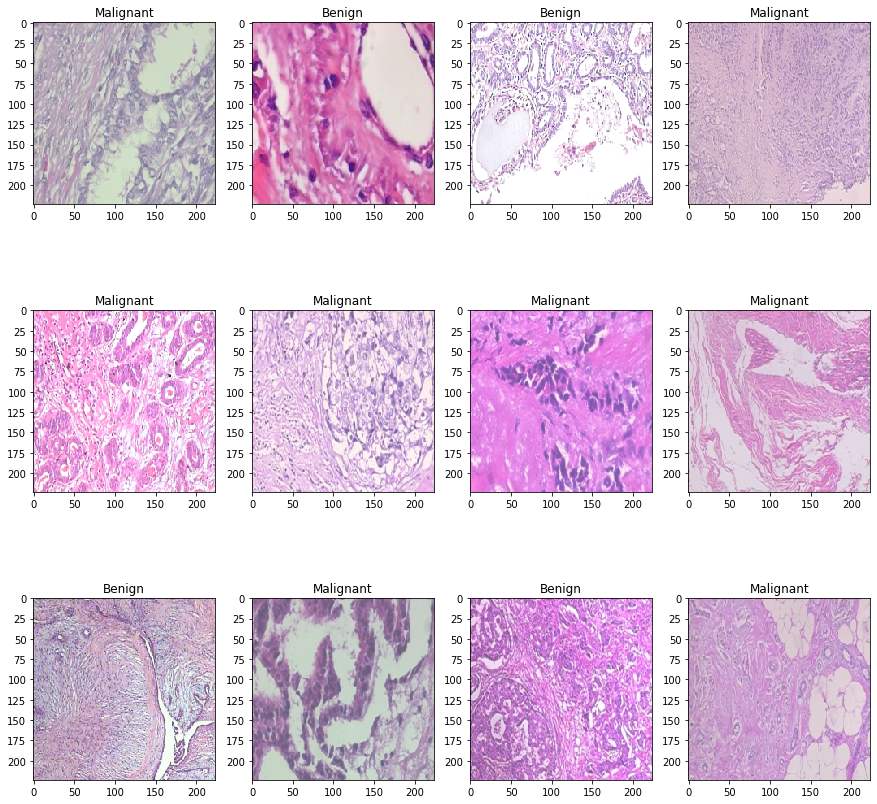

In [13]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [14]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  
        rotation_range = 90,
        horizontal_flip=True,  
        vertical_flip=True,  
    )

In [15]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [16]:
K.clear_session()
gc.collect()

resnet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 7,043,650
Trainable params: 6,957,954
Non-trainable params: 85,696
_________________________________________________________________


In [17]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.add(Dense(units=2, activation="softmax"))

In [18]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
395/395 [==============================] - 103s 225ms/step - loss: 0.6926 - accuracy: 0.6704 - val_loss: 0.6477 - val_accuracy: 0.6960
Epoch 2/20
395/395 [==============================] - 85s 215ms/step - loss: 0.6514 - accuracy: 0.6890 - val_loss: 0.6345 - val_accuracy: 0.6960
Epoch 3/20
395/395 [==============================] - 85s 214ms/step - loss: 0.6392 - accuracy: 0.6856 - val_loss: 0.6228 - val_accuracy: 0.6960
Epoch 4/20
395/395 [==============================] - 85s 215ms/step - loss: 0.6281 - accuracy: 0.6853 - val_loss: 0.6060 - val_accuracy: 0.6960
Epoch 5/20
395/395 [==============================] - 86s 216ms/step - loss: 0.6099 - accuracy: 0.7344 - val_loss: 0.5982 - val_accuracy: 0.8906- los
Epoch 6/20
395/395 [==============================] - 84s 213ms/step - loss: 0.6006 - accuracy: 0.8357 - val_loss: 0.5809 - val_accuracy: 0.8982
Epoch 7/20
395/395 [==============================] - 85s 215ms/step - loss: 0.5890 - accuracy: 0.8547 - val_loss: 0.6058 - 

In [19]:
acc = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(len(acc))

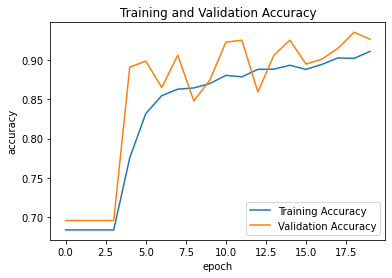

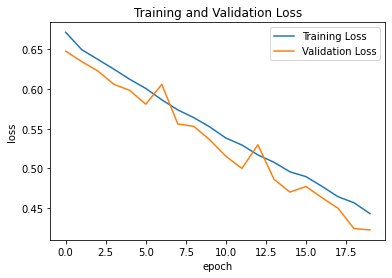

In [20]:
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title("Training and Validation Accuracy")
plt.savefig('CNNselu_acc', dpi=300, bbox_inches='tight')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Training and Validation Loss")
plt.savefig('CNNselu_loss', dpi=300, bbox_inches='tight')
plt.legend()
plt.show()